In [1]:
# pip install git+https://github.com/MIROptics/ECC2025.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.circuit import ParameterVector
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler

El __aprendizaje automático cuántico__ busca fusionar la computación cuántica con las técnicas clásicas de aprendizaje automático, con la esperanza de mejorar la eficiencia y la capacidad de procesamiento en tareas como la clasificación, la regresión y el clustering.

El objetivo principal de este taller es familiarizarse con las __maquinas cuánticas de soporte vectorial (SVM)__, utilizando el __Iris Flowers Dataset__ como ejemplo. Este un conjunto de datos ampliamente conocido en el campo del aprendizaje automático, el cual contiene características de flores de iris de tres especies diferentes. La imagen a continuación muestra una representación de las flores del conjunto de datos:

![](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/talleres/06_Clasificacion_Cuantica/img/ECC_iris_flower.png)


En esta etapa inicial, comenzamos por cargar el conjunto de datos de iris, un clásico en problemas de clasificación. Utilizamos la función `load_iris()` de la librería `sklearn.datasets` para obtener las 150 muestras que contienen características de flores iris, como la longitud y el ancho de los sépalos y los pétalos, clasificadas en tres especies distintas.

Una vez que los datos están cargados, es fundamental dividirlos en dos partes: el conjunto de entrenamiento y el conjunto de prueba. Esto es crucial para asegurarnos de que el modelo se entrene en una parte de los datos y luego se evalúe en otra, garantizando una evaluación justa. Para realizar esta división de manera aleatoria y eficiente, utilizamos la función `train_test_split` de `sklearn.model_selection`, configurando la división para que el $70\%$ de los datos se utilicen para entrenar el modelo y el $30\%$ restante para las pruebas. Llamaremos $(\vec{x}_{i},y_{i})$ a los datos de entrenamiento y $(\vec{t}_{i},s_{i})$ a los datos de prueba.

In [3]:
# Cargar el dataset
iris = load_iris()

# Crear un DataFrame para los datos del iris
data_iris = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
data_iris['target'] = iris['target']

In [4]:
data_iris.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
# Separamos en datos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(data_iris[iris.feature_names],
                                                    data_iris['target'],
                                                    test_size=0.30,
                                                    random_state=27)

Una vez que hemos preparado los datos dividiéndolos en conjuntos de entrenamiento y prueba, el siguiente paso es el preprocesamiento. Este proceso es esencial porque garantiza que las características de los datos estén en una escala adecuada para los modelos de clasificación.

Al igual que en muchos otros conjuntos de datos, las características de iris presentan distintas escalas, lo que podría afectar el rendimiento del modelo. Por ejemplo, la longitud del sépalo y el ancho del pétalo tienen unidades y rangos diferentes. Si no tratamos estas diferencias, algunas características podrían dominar el modelo, lo que afectaría la precisión de las predicciones.

Para solucionar este problema, utilizamos `MinMaxScaler` de `sklearn.preprocessing` para normalizar las características. El `MinMaxScaler` transforma las características de modo que sus valores queden en un rango de $[0, 1]$, lo que asegura que ninguna característica tenga un peso desproporcionado debido a su escala. Este paso es particularmente útil para algoritmos como el SVM, que son sensibles a la escala de las características. Al aplicar el `MinMaxScaler` tanto al conjunto de entrenamiento como al de prueba, garantizamos que ambos conjuntos estén en la misma escala, lo que permite entrenar y evaluar el modelo de manera coherente.

In [6]:
# Normalizamos los datos de entrenamiento y prueba
scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrenamiento
X_train = scaler.fit_transform(X_train)

# Transformar los datos de prueba utilizando los mismos parámetros
X_test = scaler.transform(X_test)

A través de puertas cuánticas paramétricas, específicamente utilizando puertas de rotación como $RX$ y $RY$, se crea un circuito cuántico paramétrico $U(\vec{x})$ para codificar los datos $\vec x$ en un estado cuántico $|\phi(\vec x)\rangle=U(\vec{x})|0\cdots0\rangle$. El objetivo acá es codificar los datos en un vector de dimensión superior. En nuestro caso tenemos datos son de dimensión 4, y los estados cuánticos donde los estamos codificando son de dimensión $2^4=16$.

## Problema 1: Circuito paramétrico

Crear una función que de como salida el siguiente circuito paramétrico: 

![circuit_kernel.png](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/talleres/06_Clasificacion_Cuantica/img/circuito.png)

In [7]:
# construimos circuito parametrico
def parametric_quantum_circuit():

    # Se construye un circuito cuántico de 4 qubits
    qc_dato = QuantumCircuit(4)

    # Definimos un conjunto de parámetros que serán ajustados
    theta = ParameterVector('theta', 4)
    
    ####
    # Aplicamos puertas Hadamard para generar superposición
    qc_dato.h(range(4))
    # Aplicamos puertas de rotación RX y RY para modificar el estado de los qubits
    qc_dato.rx(2 * theta[0], 0)
    qc_dato.ry(2 * theta[1], 1)
    qc_dato.ry(2 * theta[2], 2)
    qc_dato.ry(2 * theta[3], 3)
    
    # Realizamos puertas CX (controladas) entre pares de qubits ordenados
    # pairs = sorted(list(combinations(range(4), 2)), )
    pairs = [[0, 1], [0, 2], [1, 2], [0, 3], [1, 3], [2, 3]]
    
    for pair in pairs:
        i, j = pair
        qc_dato.cx(i, j)
        qc_dato.rx(2*np.pi - np.abs(theta[i]-theta[j]), j)
        qc_dato.cx(i, j)
       
    ####

    return qc_dato
    ###

Podemos visualizar el circuito parametrico utilizando la funcion ``QuantumCircuit.draw``.

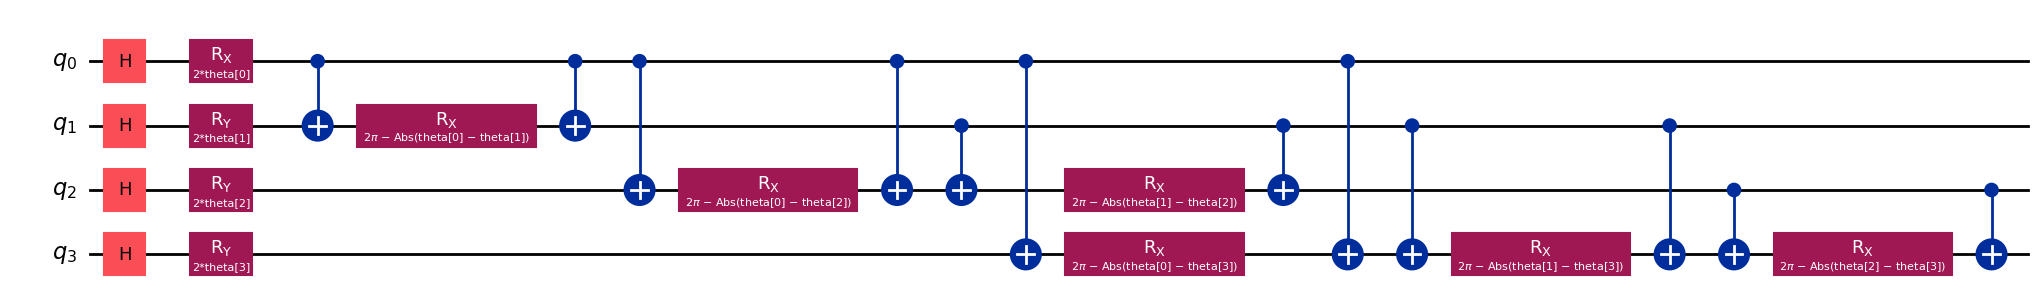

In [8]:
qc_parametric = parametric_quantum_circuit()

qc_parametric.draw('mpl',fold=-1)

La maquinas cuánticas de soporte vectorial se basan en la estimación de un kernel cuántico. Este esta dado por el overlap entre los estados cuántico que codifican cada dato $\vec{x}_j$, es decir,
$$  K_{jk} =  | \langle \phi(\vec{x}_j) | \phi(\vec{x}_k)\rangle |^2. $$

Esto requiere componer los circuitos de $U(\vec{x}_k)$ y $U(\vec{x}_j)^\dagger$, y luego realizar una medida sobre el estado $|0\cdots0\rangle$. Construyamos una función que implemente estos circuitos.

## Problema 2: Elemento del Kernel Cuántico

Crear una función que reciba dos vectores de parámetros de dimensión 4, asigne sus valores a dos copias del circuito parámetrico y evalúe el elemento del kernel cuántico. Pista, chequear los métodos `copy()`, `assign_parameters()` y `compose()`de [QuantumCircuit](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#qiskit.circuit.QuantumCircuit).


In [9]:
# contruimos un circuito de swap test
def kernel_element( dato_1, dato_2,
                    backend=Sampler(options={'seed':1}), shots=1000  ):

    value = 0 # resultado por defecto
    # Se define un circuito cuántico de 9 qubits
    qc_kernel = QuantumCircuit( 4, 4 )
    
    # Preparamos los circuitos cuánticos para los datos
    ####
    qc_dato1 = qc_parametric.copy().assign_parameters(dato_1)
    qc_dato2 = qc_parametric.copy().assign_parameters(dato_2)
    ####
    # Combinamos los circuitos cuánticos de los dos datos a comparar
    ####
    qc_kernel.compose(qc_dato1, inplace=True)
    qc_kernel.compose(qc_dato2.inverse(), inplace=True)
    ####
    # Agregamos mediciones
    qc_kernel.measure( range(4), range(4) )

    # Ejecutamos el circuito cuántico y obtenemos los resultados
    job= backend.run(qc_kernel,shots=shots)
    value=job.result().quasi_dists[0].get(0,0)

    return qc_kernel, value

/tmp/ipykernel_146891/3882598614.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  backend=Sampler(options={'seed':1}), shots=1000  ):


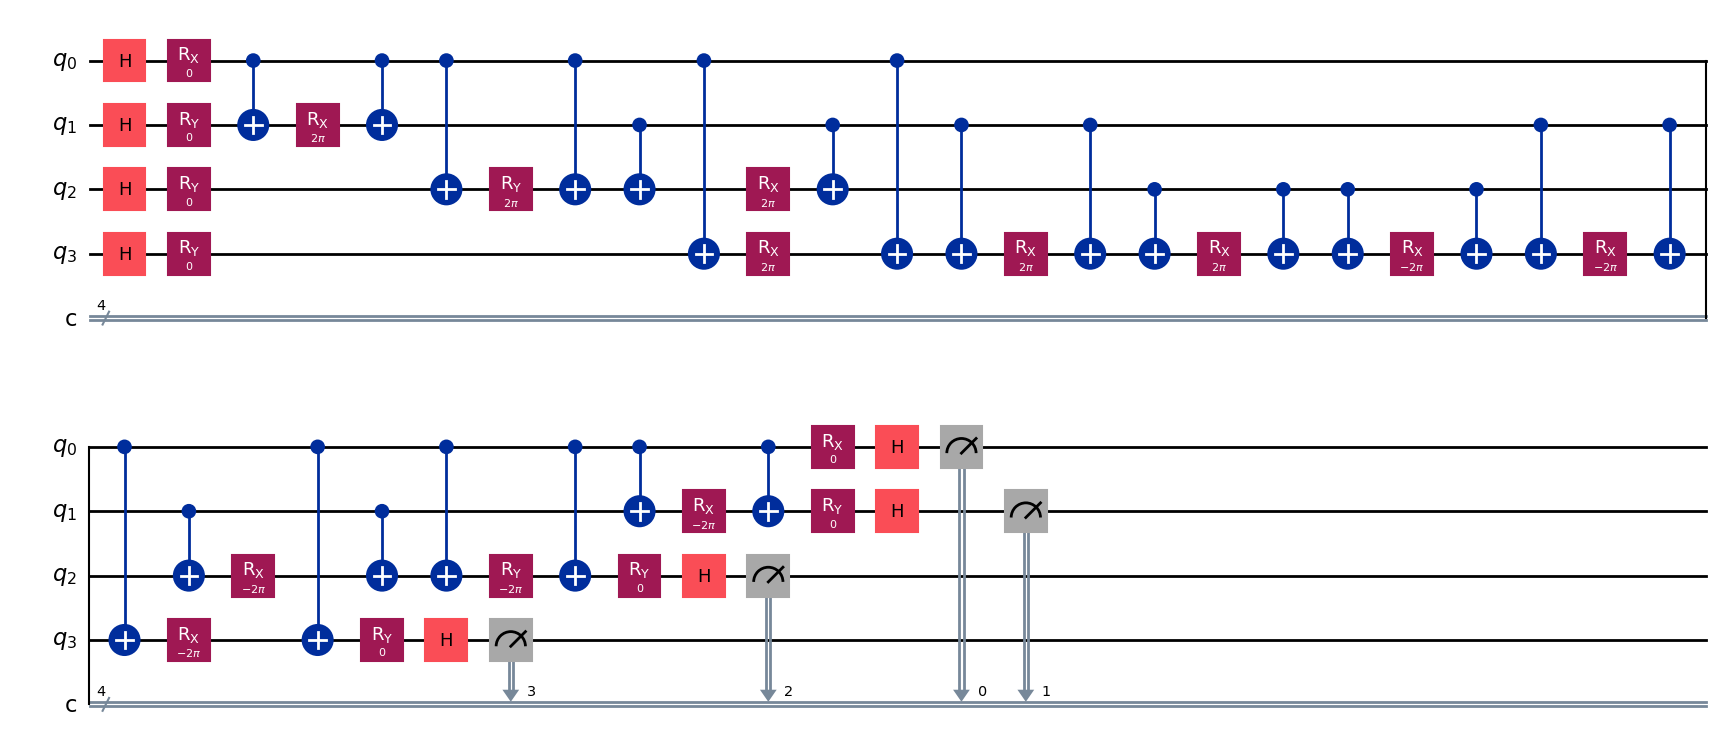

1.0


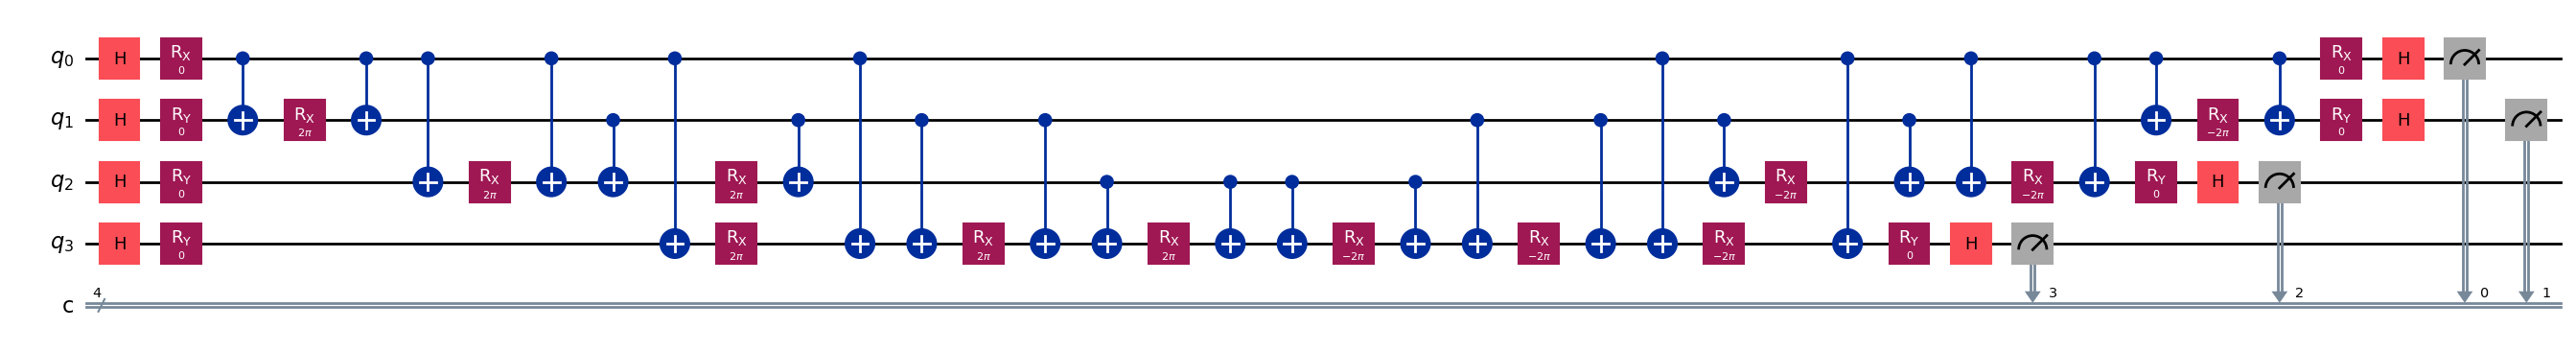

In [10]:
qc, value = kernel_element( np.zeros(4), np.zeros(4) )
print( value )
qc.draw('mpl', fold=False)

El siguiente paso en la construcción completa del kernel cuántico, que es fundamental para evaluar la similitud entre los datos de entrenamiento y los de prueba. Para ello, utilizamos la función `Quantum_Kernel` que toma como entrada los datos de entrenamiento y prueba. Primero, la función inicializa una matriz de ceros con dimensiones correspondientes a la cantidad de datos de prueba y de entrenamiento. Luego, itera sobre los datos de prueba y entrenamiento, calculando el ovelap entre cada par de datos utilizando el `kernel_element`.

In [11]:
# construimos kernel cuantico
def Quantum_Kernel( X_train, X_test=None,
                    backend=Sampler(options={'seed':1}), shots=1000 ):
    """
    X_train : vector bidimensional para entrenar
    X_test  : vector bidimensional para testear
    K_q     : Kernel cuantico
    backend : simulador o computador cuantico
    shots   : numero de shots
    """

    if X_test is None:
        X_test = X_train
    X_train = np.array(X_train)
    X_test  = np.array(X_test)

    # Inicializar la matriz de similitudes cuánticas
    K_q = np.zeros(( X_test.shape[0], X_train.shape[0]))

    values = []
    for x_test in X_test:
        for x_train in X_train:
            # Calcular el valor del kernel cuántico (swap test) entre los datos
            values.append( kernel_element( x_train, x_test,
                                            backend=backend, shots=shots )[1]  )

    l = 0
    for j, x_test in enumerate( X_test ):
        for k, x_train in enumerate( X_train):
            K_q[j,k] = values[l]
            l += 1

    return K_q

/tmp/ipykernel_146891/781306954.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  backend=Sampler(options={'seed':1}), shots=1000 ):


El uso del Quantum Kernel en el contexto de los algoritmos de aprendizaje automático cuántico permite llevar a cabo tareas de clasificación y regresión basadas en el ovelap entre los estados cuánticos asociados a los datos. Al contar con este kernel, podemos aplicar técnicas clásicas de machine learning.

Este enfoque cuántico mejora significativamente la capacidad de nuestros modelos para aprender patrones complejos en los datos, aprovechando las propiedades únicas de la computación cuántica, como la superposición, el entrelazamiento y la interferencia.

Calculamos las matrices `Kq_train` y `Kq_test` utilizando la función `Quantum_Kernel`. Estas matrices representan las similitudes entre los datos de entrenamiento y prueba.

In [12]:
Kq_train = Quantum_Kernel( X_train )
Kq_test  = Quantum_Kernel( X_train, X_test )

Después de calcular las matrices de similitud cuántica, es necesario representarlas gráficamente para observar su estructura. En este caso, representamos dos matrices: una para los datos de entrenamiento y otra para los datos de prueba.

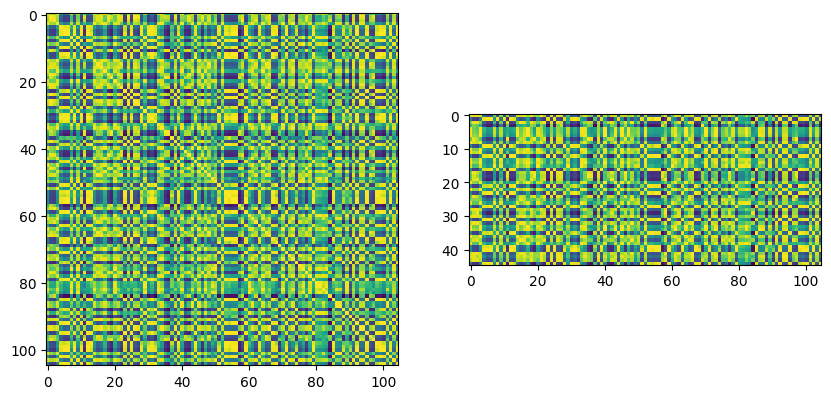

In [13]:
# Visualización de las matrices de similitudes
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
ax[0].imshow( Kq_train )
ax[1].imshow( Kq_test )

Luego de obtener los kernel cuánticos para los conjuntos de entrenamiento y prueba, podemos proceder con el entrenamiento y evaluación del modelo SVM cuántico. Esto lo haremos utilizando la función ``SVC`` de ``sklearn``.

In [14]:
# esto va en el archivo de comprobacion de respuestas
def test( Kq_train, y_train, Kq_test, y_test ):
    svm = SVC( kernel = 'precomputed' )
    svm.fit( Kq_train, y_train )
    Y_pred_quantum = svm.predict( Kq_test )
    # print( 'Fidelidad test:        ', svm.score( Kq_test, y_test ) )
    # if svm.score( Kq_test, y_test ) > 0.97:
    #     print('Tu discrimindor alcanza una calidad superior al 97%.')
    # else:
    #     print('Vuelve a los desafios anteriores para intentar mejorar tu discriminador.')
    quantum = confusion_matrix(y_test, Y_pred_quantum)

    ConfusionMatrixDisplay(confusion_matrix=quantum).plot();
    print(classification_report(y_test, Y_pred_quantum))

    return None

Este código entrena un clasificador SVM con un kernel cuántico precomputado y evalúa el desempeño en los datos de prueba, mostrando la fidelidad del modelo y una matriz de confusión que representa las predicciones del modelo frente a los valores reales. Además, se muestra un informe de la clasificación.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.94      0.94      0.94        16
           2       0.94      0.94      0.94        17

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



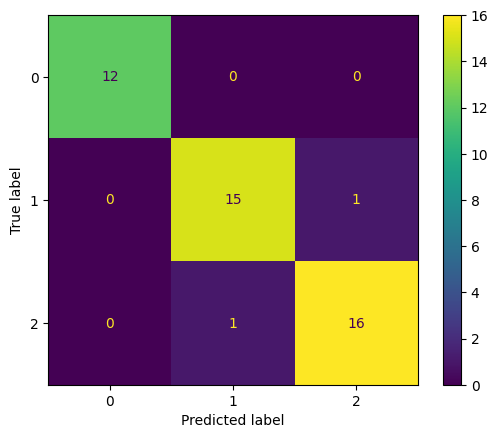

In [15]:
test( Kq_train, y_train, Kq_test, y_test )

Una parte fundamental del análisis consiste en comparar el desempeño de los modelos cuánticos con los modelos clásicos. Para este propósito, entrenamos y evaluamos modelos SVM clásicos utilizando diferentes kernels estándar, como el kernel lineal, el kernel radial (RBF), y el kernel polinómico.

Cada uno de estos modelos se ajusta a los datos de entrenamiento y se evalúa en el conjunto de prueba. Posteriormente, se calculan métricas como la fidelidad del modelo y se visualizan las matrices de confusión para analizar el comportamiento de cada kernel. Este análisis comparativo permite identificar las ventajas y limitaciones de los modelos cuánticos en relación con los clásicos, destacando las condiciones en las que cada enfoque resulta más efectivo.

In [16]:
def ker_lineal( X_train, y_train, X_test, y_test ):
    svm = SVC( kernel = 'linear' )
    svm.fit( X_train, y_train )
    Y_pred_quantum = svm.predict( X_test )
    # print( 'Fidelidad test:        ', svm.score( X_test, y_test ) )

    quantum = confusion_matrix(y_test, Y_pred_quantum)

    ConfusionMatrixDisplay(confusion_matrix=quantum).plot();
    print(classification_report(y_test, Y_pred_quantum))

    return None

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.88      0.94      0.91        16
           2       0.94      0.88      0.91        17

    accuracy                           0.93        45
   macro avg       0.94      0.94      0.94        45
weighted avg       0.93      0.93      0.93        45



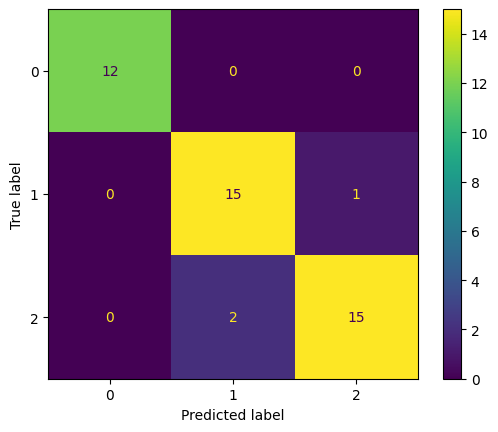

In [17]:
ker_lineal( X_train, y_train, X_test, y_test )

In [18]:
def ker_rbf( X_train, y_train, X_test, y_test ):
    svm = SVC( kernel = 'rbf' )
    svm.fit( X_train, y_train )
    Y_pred_quantum = svm.predict( X_test )
    # print( 'Fidelidad test:        ', svm.score( X_test, y_test ) )

    quantum = confusion_matrix(y_test, Y_pred_quantum)

    ConfusionMatrixDisplay(confusion_matrix=quantum).plot();
    print(classification_report(y_test, Y_pred_quantum))

    return None

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.88      0.88      0.88        16
           2       0.88      0.88      0.88        17

    accuracy                           0.91        45
   macro avg       0.92      0.92      0.92        45
weighted avg       0.91      0.91      0.91        45



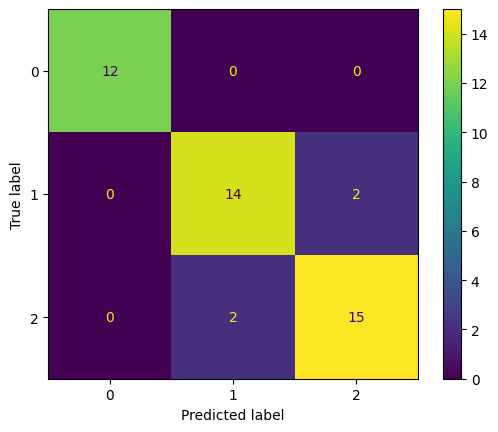

In [19]:
ker_rbf( X_train, y_train, X_test, y_test )

In [20]:
def ker_poly( X_train, y_train, X_test, y_test ):
    svm = SVC( kernel = 'poly' )
    svm.fit( X_train, y_train )
    Y_pred_quantum = svm.predict( X_test )
    # print( 'Fidelidad test:        ', svm.score( X_test, y_test ) )

    quantum = confusion_matrix(y_test, Y_pred_quantum)

    ConfusionMatrixDisplay(confusion_matrix=quantum).plot();
    print(classification_report(y_test, Y_pred_quantum))

    return None

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.88      0.88      0.88        16
           2       0.88      0.88      0.88        17

    accuracy                           0.91        45
   macro avg       0.92      0.92      0.92        45
weighted avg       0.91      0.91      0.91        45



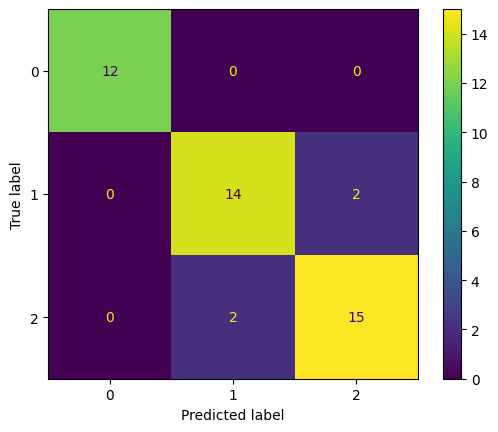

In [21]:
ker_poly( X_train, y_train, X_test, y_test )

Para finalizar, queremos detacar que para implementaciones avanzadas de SVM con qiskit es recomendable utilizar los módulos ``qiskit_machine_learning.kernels`` y ``qiskit_machine_learning.state_fidelities``.

## Contacto

Victor Gonzalez AVella <br>
Estudiante de Doctorado en Física mención Física-Matemática<br>
Universidad de Antofagasta<br>
victor.gonzalez.avella@ua.cl<br>